# Orthorectify GOES-R RGB images


Orthorectify red, "green", and blue bands of GOES ABI for a single set of observations from GOES-16 and GOES-17.

This notebook demonstrates the use of the [goes_ortho](https://github.com/spestana/goes-ortho/blob/master/examples/orthorectify_abi_example.ipynb) functions, and RGB plotting is based on [this notebook](https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances).


In [1]:
import sys
sys.path.append('/home/jovyan/git/goes-ortho')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import goes_ortho

# for plotting geotiff rasters
import rasterio as rio
import rasterio.plot as rioplt

I am using [this](https://github.com/uw-cryo/asp-binder-demo/blob/6f03afadc7f4c6e13422da6d5f480c7f6762b47b/asp_binder_utils.py) extremely handy function, `get_dem()` from the [UW Terrain Analysis and Cryosphere Observation Lab](https://github.com/uw-cryo).

In [3]:
api_key = '585b1d1639bc5ef8a4a5bdea7e45a8d1'

In [4]:
dem_filepath = 'example_dem.tif'

goes_ortho.get_data.get_dem(demtype='SRTMGL1_E', bounds=(-119.7, 37.6 , -119.1, 38.2), api_key=api_key, out_fn=dem_filepath, proj='EPSG:4326')

https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-119.7&south=37.6&east=-119.1&north=38.2&outputFormat=GTiff&API_Key=585b1d1639bc5ef8a4a5bdea7e45a8d1


'example_dem.tif'

---

Use the `download-goes.py` script to download GOES ABI-L1b-RadC products for channels 1, 2, and 3, for both GOES-16 and GOES-17 on March 3rd, 2020.

In [5]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C01 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [6]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C02 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [7]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C03 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [8]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C01 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [9]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C02 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [10]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C03 --bounds 30 50 -125 -105 --dir /storage/GOES/

Here I just have lists of the GOES-16 and -17 ABI channel 1, 2, and 3 images I'll be orthorectifying, and then using to make RGB images.

In [11]:
from glob import glob

In [12]:
goes16_c01 = glob('/home/jovyan/tmp/goes16/2020/3/3/ABI-L1b-RadC/00/C01/*.nc')[0]
goes16_c02 = glob('/home/jovyan/tmp/goes16/2020/3/3/ABI-L1b-RadC/00/C02/*.nc')[0]
goes16_c03 = glob('/home/jovyan/tmp/goes16/2020/3/3/ABI-L1b-RadC/00/C03/*.nc')[0]
goes16_images = [goes16_c01, goes16_c02, goes16_c03]

goes17_c01 = glob('/home/jovyan/tmp/goes17/2020/3/3/ABI-L1b-RadC/00/C01/*.nc')[0]
goes17_c02 = glob('/home/jovyan/tmp/goes17/2020/3/3/ABI-L1b-RadC/00/C02/*.nc')[0]
goes17_c03 = glob('/home/jovyan/tmp/goes17/2020/3/3/ABI-L1b-RadC/00/C03/*.nc')[0]
goes17_images = [goes17_c01, goes17_c02, goes17_c03]

In [13]:
## GOES-16
#goes16_images = ['/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200630001139_e20200630003512_c20200630003557.nc',
#                 '/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G16_s20200630001139_e20200630003512_c20200630003542.nc',
#                 '/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C03/OR_ABI-L1b-RadC-M6C03_G16_s20200630001139_e20200630003512_c20200630003571.nc']
#
## GOES-17
#goes17_images = ['/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G17_s20200630001176_e20200630003549_c20200630004011.nc',
#                 '/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G17_s20200630001176_e20200630003549_c20200630003571.nc',
#                 '/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C03/OR_ABI-L1b-RadC-M6C03_G17_s20200630001176_e20200630003549_c20200630004001.nc']

---

For each of the three GOES-16 images, create an "ortho map" with `goes_ortho.make_ortho_map()` that describes how the original image in ABI scan angle units translates to latitude and longitude, given the parallax effect caused by local terrain. Then use this "ortho map" in `goes_ortho.orthorectify_abi()` to orthorectify the ABI image and output a new NetCDF file clipped to the bounds of the DEM we're using.

In [14]:
for image_path in goes16_images:

    # create a new filename
    new_filename = image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'
    
    # create the mapping between scan angle coordinates and lat/lon given the GOES satellite position and our DEM
    ortho_map = goes_ortho.orthorectify.make_ortho_map(image_path, 
                                                       dem_filepath)

    # specify which data variables from the original ABI product we want in our new orthorectified file
    data_vars = ['Rad'] # I'm only selecting the Radiance product. 
    
    # Note, because we've supplied Radiance to orthorectify_abi(), we will also get reflectance (for bands 1-6) or brightness temperature (for bands 7-16)
    
    # Apply the "ortho map" and save a new NetCDF file with data variables from the original file
    ds = goes_ortho.orthorectify.orthorectify_abi(image_path, 
                                                  ortho_map,
                                                  data_vars,
                                                  out_filename=new_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset> Size: 93MB
Dimensions:         (latitude: 2160, longitude: 2160)
Coordinates:
  * longitude       (longitude) float64 17kB -119.7 -119.7 ... -119.1 -119.1
  * latitude        (latitude) float64 17kB 38.2 38.2 38.2 ... 37.6 37.6 37.6
    dem_px_angle_x  (latitude, longitude) float64 37MB -0.09079 ... -0.09071
    dem_px_angle_y  (latitude, longitude) float64 37MB 0.1013 0.1013 ... 0.1002
Data variables:
    elevation       (latitude, longitude) float32 19MB 2.86e+03 ... 2.391e+03
Attributes: (12/21)
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                    

Plot an imaginary pixel footprint to see the point of view of the GOES ABI and in map view.

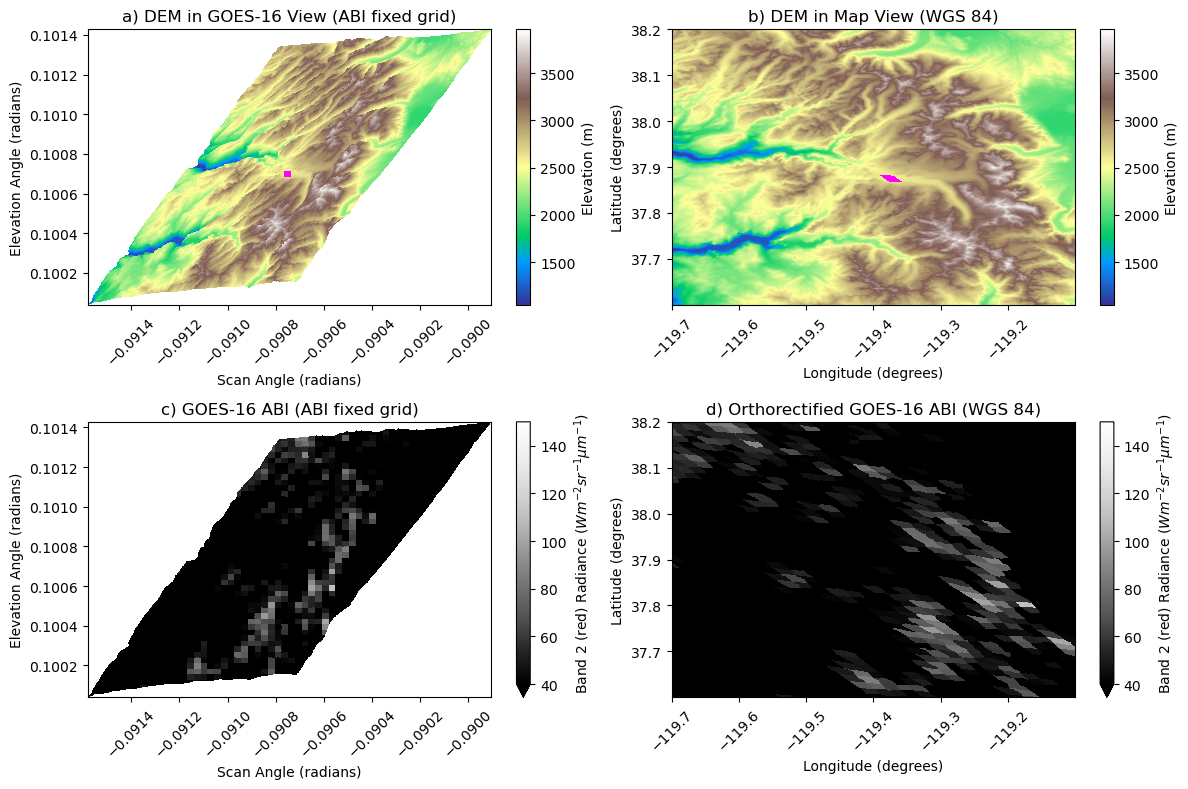

In [15]:
fig, axes = plt.subplots(2,2, figsize=(12,8), tight_layout=True)

[ax1, ax2, ax3, ax4] = axes.flatten()

ortho_map.elevation.plot(x='dem_px_angle_x', y='dem_px_angle_y',
                        cmap='terrain',
                        ax=ax1,
                        cbar_kwargs=dict(label='Elevation (m)'))

# plot a single demo pixel footprint
ifov = 0.000028 # radians
ortho_map.elevation.where((ortho_map.dem_px_angle_x >= -0.09075-(ifov/2)) & (ortho_map.dem_px_angle_x <= -0.09075+(ifov/2))) \
                    .where((ortho_map.dem_px_angle_y >= 0.1007-(ifov/2)) & (ortho_map.dem_px_angle_y <= 0.1007+(ifov/2))) \
                    .plot(x='dem_px_angle_x', y='dem_px_angle_y', ax=ax1, cmap='spring_r', vmin=-100, vmax=0, alpha=1, add_colorbar=False)

ax1.set_title('a) DEM in GOES-16 View (ABI fixed grid)')
ax1.set_ylabel('Elevation Angle (radians)')
ax1.set_xlabel('Scan Angle (radians)')


ortho_map.elevation.plot(cmap='terrain',
                        ax=ax2,
                        cbar_kwargs=dict(label='Elevation (m)'))

# plot the same single demo pixel footprint
ortho_map.elevation.where((ortho_map.dem_px_angle_x >= -0.09075-(ifov/2)) & (ortho_map.dem_px_angle_x <= -0.09075+(ifov/2))) \
                    .where((ortho_map.dem_px_angle_y >= 0.1007-(ifov/2)) & (ortho_map.dem_px_angle_y <= 0.1007+(ifov/2))) \
                    .plot(ax=ax2, cmap='spring_r', vmin=-100, vmax=0, alpha=1, add_colorbar=False)

ax2.set_title('b) DEM in Map View (WGS 84)')
ax2.set_ylabel('Latitude (degrees)')
ax2.set_xlabel('Longitude (degrees)');

ortho_map.Rad.plot(x='dem_px_angle_x', y='dem_px_angle_y',
                   cmap='Greys_r',
                        ax=ax3, vmin=40, vmax=150,
                        cbar_kwargs=dict(label=r'Band 2 (red) Radiance ($W m^{-2} sr^{-1} \mu m^{-1}$)'))
ax3.set_title('c) GOES-16 ABI (ABI fixed grid)')
ax3.set_ylabel('Elevation Angle (radians)')
ax3.set_xlabel('Scan Angle (radians)')


ortho_map.Rad.plot(cmap='Greys_r',
                        ax=ax4, vmin=40, vmax=150,
                        cbar_kwargs=dict(label=r'Band 2 (red) Radiance ($W m^{-2} sr^{-1} \mu m^{-1}$)'))
ax4.set_title('d) Orthorectified GOES-16 ABI (WGS 84)')
ax4.set_ylabel('Latitude (degrees)')
ax4.set_xlabel('Longitude (degrees)');

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation = 45)

Now do the same for the three GOES-17 images.

In [16]:
for image_path in goes17_images:

    # create a new filename
    new_filename = image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'
    
    # create the mapping between scan angle coordinates and lat/lon given the GOES satellite position and our DEM
    ortho_map = goes_ortho.orthorectify.make_ortho_map(image_path, 
                                                       dem_filepath)

    # specify which data variables from the original ABI product we want in our new orthorectified file
    data_vars = ['Rad'] # I'm only selecting the Radiance product. 
    
    # Note, because we've supplied Radiance to orthorectify_abi(), we will also get reflectance (for bands 1-6) or brightness temperature (for bands 7-16)
    
    # Apply the "ortho map" and save a new NetCDF file with data variables from the original file
    ds = goes_ortho.orthorectify.orthorectify_abi(image_path, 
                                                  ortho_map,
                                                  data_vars,
                                                  out_filename=new_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset> Size: 93MB
Dimensions:         (latitude: 2160, longitude: 2160)
Coordinates:
  * longitude       (longitude) float64 17kB -119.7 -119.7 ... -119.1 -119.1
  * latitude        (latitude) float64 17kB 38.2 38.2 38.2 ... 37.6 37.6 37.6
    dem_px_angle_x  (latitude, longitude) float64 37MB 0.03972 ... 0.04141
    dem_px_angle_y  (latitude, longitude) float64 37MB 0.1046 0.1046 ... 0.1033
Data variables:
    elevation       (latitude, longitude) float32 19MB 2.86e+03 ... 2.391e+03
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                     

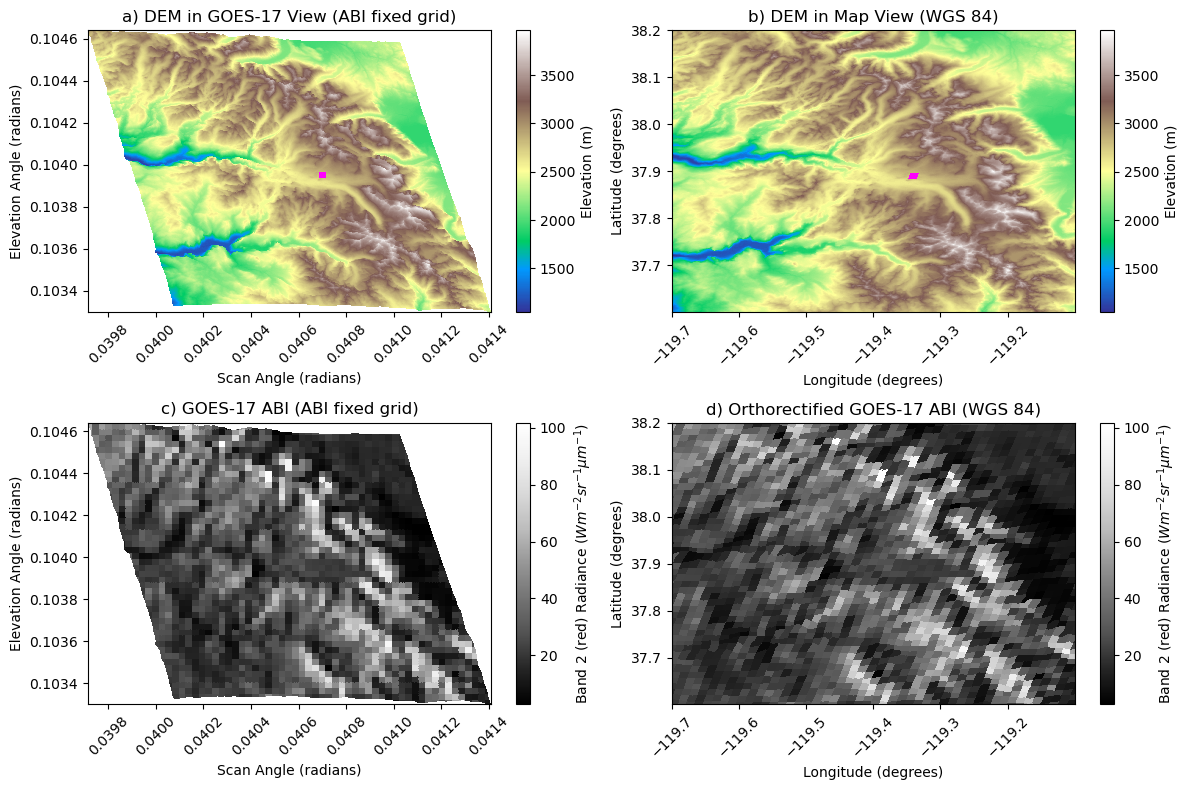

In [17]:
fig, axes = plt.subplots(2,2, figsize=(12,8), tight_layout=True)

[ax1, ax2, ax3, ax4] = axes.flatten()

ortho_map.elevation.plot(x='dem_px_angle_x', y='dem_px_angle_y',
                        cmap='terrain',
                        ax=ax1,
                        cbar_kwargs=dict(label='Elevation (m)'))

# plot a single demo pixel footprint
ifov = 0.000028 # radians
ortho_map.elevation.where((ortho_map.dem_px_angle_x >= 0.0407-(ifov/2)) & (ortho_map.dem_px_angle_x <= 0.0407+(ifov/2))) \
                    .where((ortho_map.dem_px_angle_y >= 0.10395-(ifov/2)) & (ortho_map.dem_px_angle_y <= 0.10395+(ifov/2))) \
                    .plot(x='dem_px_angle_x', y='dem_px_angle_y', ax=ax1, cmap='spring_r', vmin=-100, vmax=0, alpha=1, add_colorbar=False)

ax1.set_title('a) DEM in GOES-17 View (ABI fixed grid)')
ax1.set_ylabel('Elevation Angle (radians)')
ax1.set_xlabel('Scan Angle (radians)')


ortho_map.elevation.plot(cmap='terrain',
                        ax=ax2,
                        cbar_kwargs=dict(label='Elevation (m)'))

# plot the same single demo pixel footprint
ortho_map.elevation.where((ortho_map.dem_px_angle_x >= 0.0407-(ifov/2)) & (ortho_map.dem_px_angle_x <= 0.0407+(ifov/2))) \
                    .where((ortho_map.dem_px_angle_y >= 0.10395-(ifov/2)) & (ortho_map.dem_px_angle_y <= 0.10395+(ifov/2))) \
                    .plot(ax=ax2, cmap='spring_r', vmin=-100, vmax=0, alpha=1, add_colorbar=False)

ax2.set_title('b) DEM in Map View (WGS 84)')
ax2.set_ylabel('Latitude (degrees)')
ax2.set_xlabel('Longitude (degrees)');

ortho_map.Rad.plot(x='dem_px_angle_x', y='dem_px_angle_y',
                   cmap='Greys_r',
                        ax=ax3,
                        cbar_kwargs=dict(label=r'Band 2 (red) Radiance ($W m^{-2} sr^{-1} \mu m^{-1}$)'))
ax3.set_title('c) GOES-17 ABI (ABI fixed grid)')
ax3.set_ylabel('Elevation Angle (radians)')
ax3.set_xlabel('Scan Angle (radians)')


ortho_map.Rad.plot(cmap='Greys_r',
                        ax=ax4,
                        cbar_kwargs=dict(label=r'Band 2 (red) Radiance ($W m^{-2} sr^{-1} \mu m^{-1}$)'))
ax4.set_title('d) Orthorectified GOES-17 ABI (WGS 84)')
ax4.set_ylabel('Latitude (degrees)')
ax4.set_xlabel('Longitude (degrees)');

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation = 45)

Open our six new orthorectified datasets:

In [18]:
# GOES-16
goes_16_C01 = xr.open_dataset('OR_ABI-L1b-RadC-M6C01_G16_s20200630031139_e20200630033512_c20200630033571_orthorectified.nc')
goes_16_C02 = xr.open_dataset('OR_ABI-L1b-RadC-M6C02_G16_s20200630046139_e20200630048512_c20200630048541_orthorectified.nc')
goes_16_C03 = xr.open_dataset('OR_ABI-L1b-RadC-M6C03_G16_s20200630006139_e20200630008512_c20200630008571_orthorectified.nc')

# GOES-17
goes_17_C01 = xr.open_dataset('OR_ABI-L1b-RadC-M6C01_G17_s20200630016176_e20200630018549_c20200630019007_orthorectified.nc')
goes_17_C02 = xr.open_dataset('OR_ABI-L1b-RadC-M6C02_G17_s20200630046176_e20200630048549_c20200630048581_orthorectified.nc')
goes_17_C03 = xr.open_dataset('OR_ABI-L1b-RadC-M6C03_G17_s20200630051176_e20200630053549_c20200630053593_orthorectified.nc')

In [55]:
goes16_RGB, goes16_RGB_veggie = goes_ortho.rad.makeABIrgb_fromReflectance(normalize(goes_16_C02.ref.data), 
                                                                          normalize(goes_16_C03.ref.data), 
                                                                          normalize(goes_16_C01.ref.data))

In [56]:
goes17_RGB, goes17_RGB_veggie = goes_ortho.rad.makeABIrgb_fromReflectance(normalize(goes_17_C02.ref.data), 
                                                                          normalize(goes_17_C03.ref.data), 
                                                                          normalize(goes_17_C01.ref.data))

In [57]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [58]:
merged_RGB, merged_RGB_veggie = goes_ortho.rad.makeABIrgb_fromReflectance(normalize((goes_17_C02.ref.data + goes_16_C02.ref.data)/2),
                                                                          normalize((goes_17_C03.ref.data + goes_16_C03.ref.data)/2),
                                                                          normalize((goes_17_C01.ref.data + goes_16_C01.ref.data)/2))

Plot the GOES-16 and -7 RGB images that have been orthorectified:

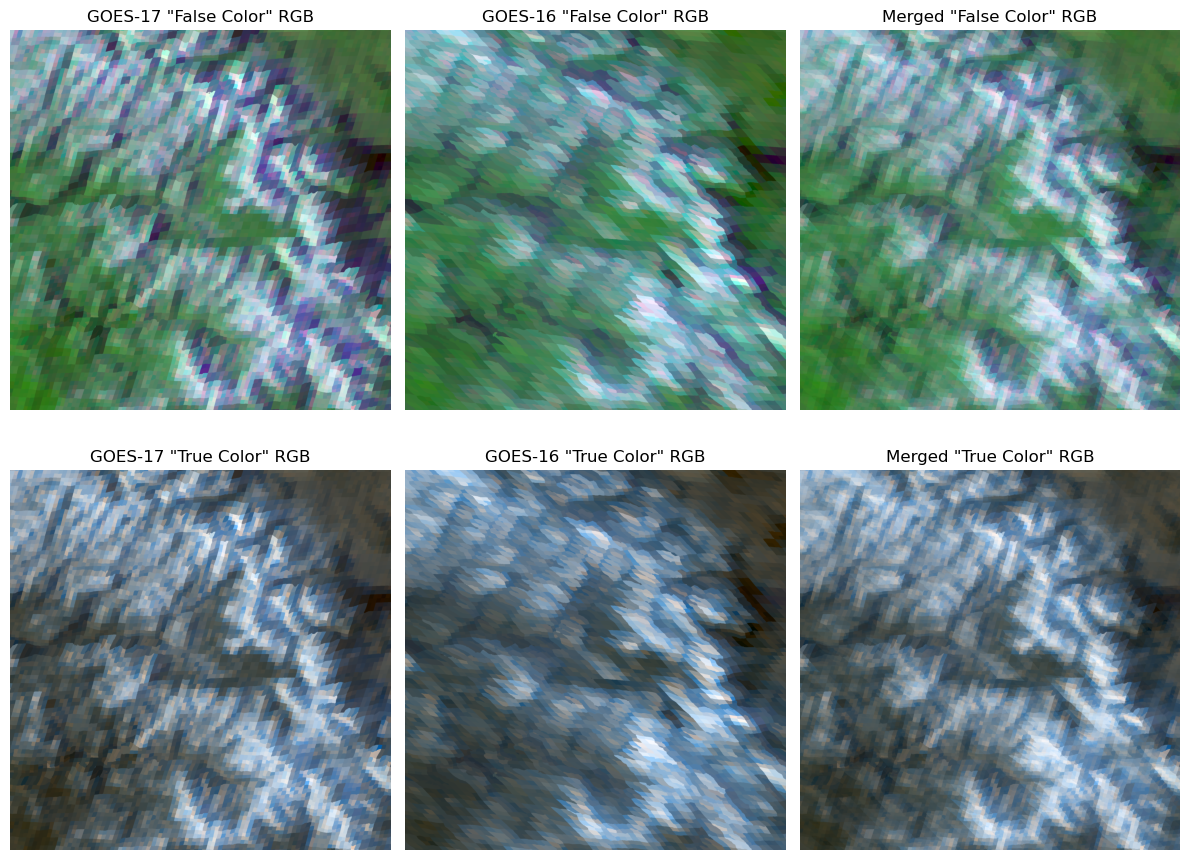

In [59]:
# set up plot figure
fig, ax = plt.subplots(2, 3, figsize=(12, 10), tight_layout=True)
[ax1, ax2, ax3, ax4, ax5, ax6] = ax.flatten()

# GOES-17 False Color: RGB using the NIR "Veggie" Band
ax1.imshow(goes17_RGB_veggie)
ax1.set_title('GOES-17 "False Color" RGB')
ax1.axis('off')

# GOES-16 False Color: RGB using the NIR "Veggie" Band
ax2.imshow(goes16_RGB_veggie)
ax2.set_title('GOES-16 "False Color" RGB')
ax2.axis('off')

# GOES-16 False Color: RGB using the NIR "Veggie" Band
ax3.imshow(merged_RGB_veggie)
ax3.set_title('Merged "False Color" RGB')
ax3.axis('off')

# GOES-17 True Color: RGB for the true color image
ax4.imshow(goes17_RGB)
ax4.set_title('GOES-17 "True Color" RGB')
ax4.axis('off')

# GOES-16 True Color: RGB for the true color image
ax5.imshow(goes16_RGB)
ax5.set_title('GOES-16 "True Color" RGB')
ax5.axis('off');

# GOES-16 True Color: RGB for the true color image
ax6.imshow(merged_RGB)
ax6.set_title('Merged "True Color" RGB')
ax6.axis('off');

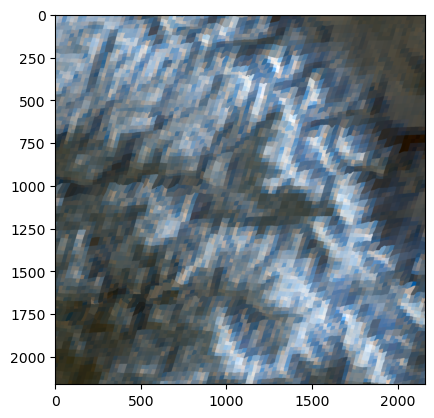

In [60]:
plt.imshow(goes17_RGB)
plt.savefig('17_norm.jpg',dpi=300)